## Setup

In [53]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [55]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [4]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [5]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Once you've found the variable or variables you want, you can plug them into this code under `variables`. 

In [106]:
%%R 

# the variable B01003_001 was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/

# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        nature_pop="B05001_005",     
                        nature_born = "B05011_004"        
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

nyc_census_data

#"B19013_001"


Simple feature collection with 4654 features and 5 fields (with 2 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                       NAME    variable estimate
1  36081014700  Census Tract 147, Queens County, New York  nature_pop      614
2  36081014700  Census Tract 147, Queens County, New York nature_born       47
3  36047058400   Census Tract 584, Kings County, New York  nature_pop     1807
4  36047058400   Census Tract 584, Kings County, New York nature_born      297
5  36061006900 Census Tract 69, New York County, New York  nature_pop      152
6  36061006900 Census Tract 69, New York County, New York nature_born       41
7  36047073000   Census Tract 730, Kings County, New York  nature_pop     1027
8  36047073000   Census Tract 730, Kings County, New York nature_born       53
9  36047100400  Census Tract 1004, Kings Co

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [107]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  # pivot from wide to long
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )

nyc_census_data

Simple feature collection with 2327 features and 6 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 7
   GEOID       NAME                                 geometry nature_pop_estimate
   <chr>       <chr>                      <MULTIPOLYGON [°]>               <dbl>
 1 36081014700 Census Tract 147, … (((-73.9137 40.76548, -7…                 614
 2 36047058400 Census Tract 584, … (((-73.96103 40.59616, -…                1807
 3 36061006900 Census Tract 69, N… (((-74.02064 40.73039, -…                 152
 4 36047073000 Census Tract 730, … (((-73.93345 40.6257, -7…                1027
 5 36047100400 Census Tract 1004,… (((-73.90735 40.63083, -…                1046
 6 36047055700 Census Tract 557, … (((-73.96279 40.72256, -…                 105
 7 36005022101 Census Tract 221.0… (((-73.92012 40.83759, -…                 976
 8 36081047000 Census Tr

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

In this example, we create a column called `borough` by extracting the borough from the `NAME` column.

_(hint, I used GitHub Copilot -- a tool similar to ChatGPT -- to do this...see my prompt in the comments)_

In [108]:
%%R 

# Extract borough name from NAME by splitting strings like 
# "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim()
    )

### Step 5 | Example Plots

Let's practice with histograms

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


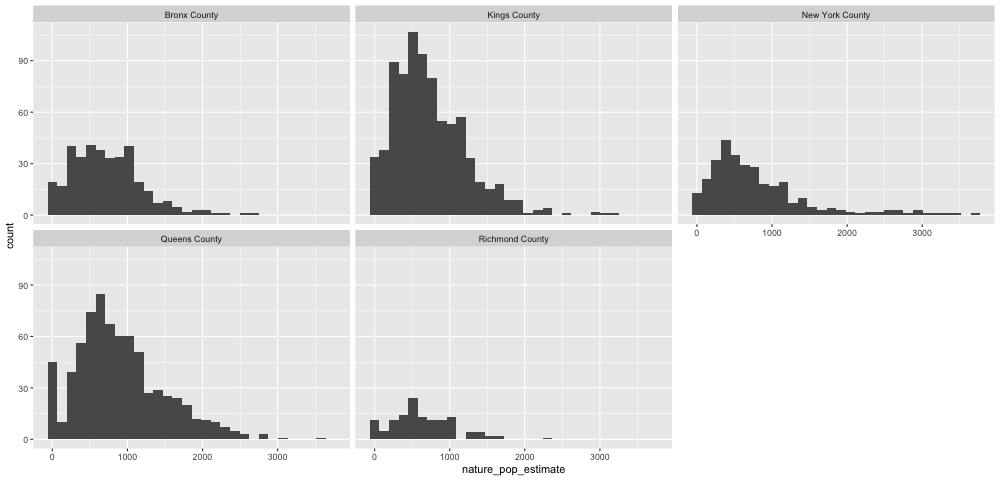

In [110]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=nature_pop_estimate) +
    geom_histogram() + 
    facet_wrap(~borough) 

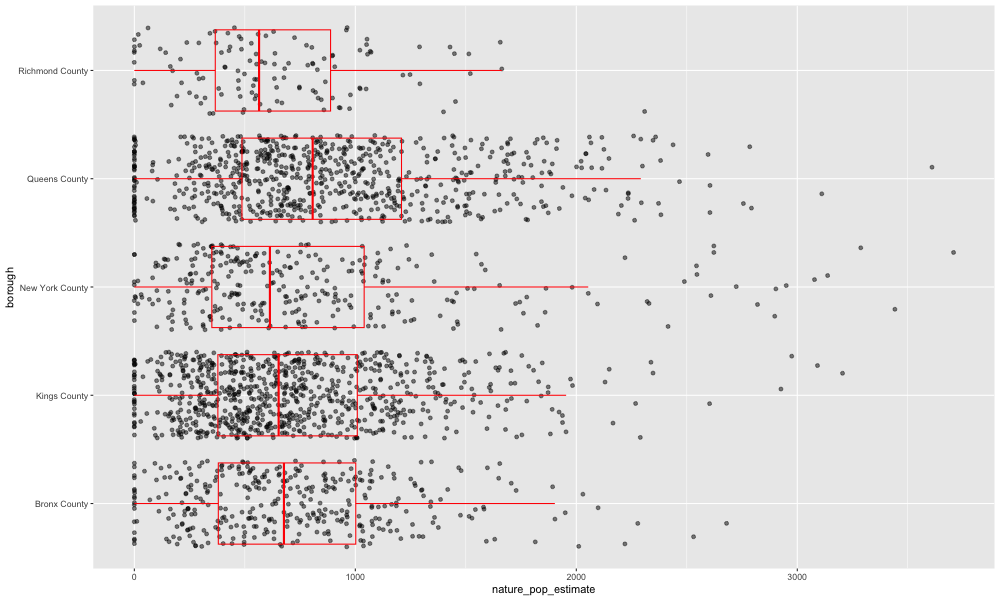

In [111]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=nature_pop_estimate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

In [112]:
%%R 

library(tigris)

# remove water from the shapefiles
# https://walker-data.com/tidycensus/articles/spatial-data.html
nyc_census_data <- nyc_census_data %>% 
    erase_water()

Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


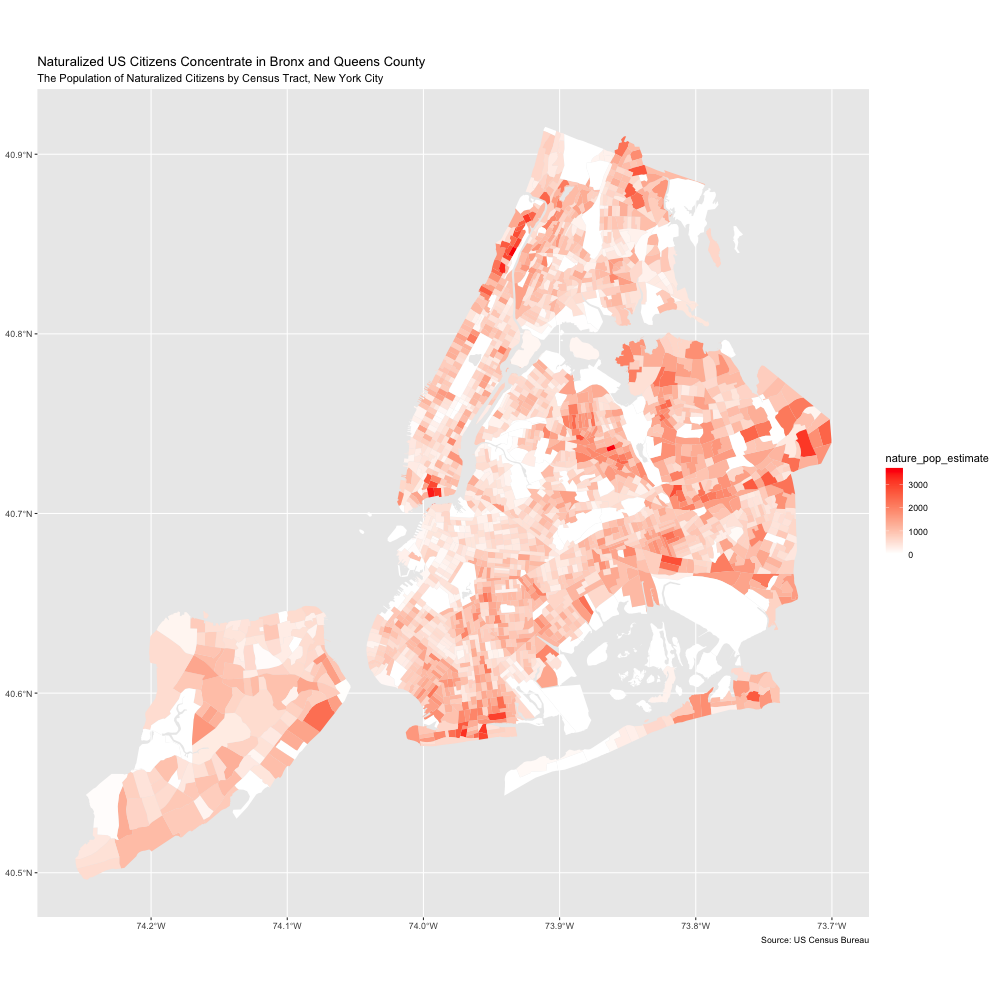

In [114]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = nature_pop_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "Naturalized US Citizens Concentrate in Bronx and Queens County",
    subtitle = "The Population of Naturalized Citizens by Census Tract, New York City",
    caption = "Source: US Census Bureau"
  )
